---
# SurfinWaves - Tutorial Notebook 3
This routine interpolates different dispersion curves from the same line

##### author: Alberto Carrera
---

In [8]:
import numpy as np
import pandas as pd
import os
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

location = 'Bagolino'
datadir = '../data/masw/'
figdir = '../figures/'
outdir = os.path.join(datadir, 'disp_curves/')
mode_n = str(0)

### 1. Pick up the DC files (.txt)

In [9]:
# Function to select files from a directory
def select_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(initialdir=datadir)
    return file_paths

# Get list of input files
file_list = select_files()

In [18]:
file_list

('C:/Users/albyr/OneDrive - Università degli Studi di Padova/LAVORO/StudioGeologiaAmbiente/2025/3.Bagolino/data/masw/disp_curves/11.0a.txt',
 'C:/Users/albyr/OneDrive - Università degli Studi di Padova/LAVORO/StudioGeologiaAmbiente/2025/3.Bagolino/data/masw/disp_curves/11.0b.txt',
 'C:/Users/albyr/OneDrive - Università degli Studi di Padova/LAVORO/StudioGeologiaAmbiente/2025/3.Bagolino/data/masw/disp_curves/11.0c.txt',
 'C:/Users/albyr/OneDrive - Università degli Studi di Padova/LAVORO/StudioGeologiaAmbiente/2025/3.Bagolino/data/masw/disp_curves/11.0d.txt')

### 2. Interpolate just the common portions

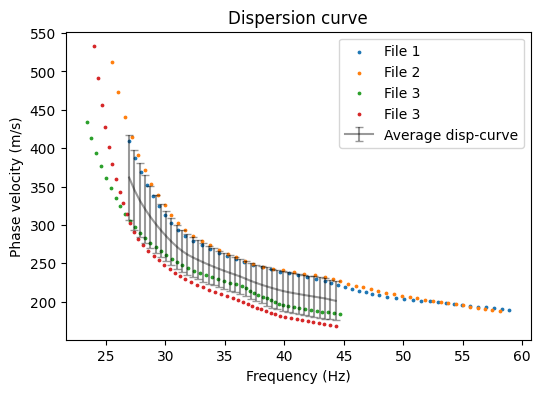

In [36]:
# Extract x and y values from each file and store in separate arrays
x = []
y = []
for file_path in file_list:
    if file_path.endswith('.txt'):
        data = np.loadtxt(file_path, skiprows=1)
        x.append(data[:,0])
        y.append(data[:,1])

# set the filename
basename = os.path.basename(file_list[0])
filename = basename.split('_')[0]

# Find the minimum and maximum x values across all files
xmin = np.min([np.min(x[i]) for i in range(len(x))])
xmax = np.max([np.max(x[i]) for i in range(len(x))])

# Apply filter to remove values above max from both curves
#x0_min, x0_max = np.min(x[0]), np.max(x[0])
#x1_min, x1_max = np.min(x[1]), np.max(x[1])

# Create common x values for interpolation
#common_x = np.linspace(xmin, xmax, 100)
#common_x = common_x[(common_x >= x0_min) & (common_x>= x1_min)]
#common_x = common_x[(common_x <= x0_max) & (common_x<= x1_max)]

# Trova il range comune tra tutti i file
x_mins = [np.min(xi) for xi in x]
x_maxs = [np.max(xi) for xi in x]
x_common_min = np.max(x_mins)  # massimo dei minimi → inizio del range comune
x_common_max = np.min(x_maxs)  # minimo dei massimi → fine del range comune

# Crea valori comuni di x per interpolazione
common_x = np.linspace(x_common_min, x_common_max,40)

# Interpolate each set of y values onto the common x values
y_interp = []
for i in range(len(y)):
    interp = np.interp(common_x, x[i], y[i])
    y_interp.append(interp)

# Calculate the mean vector and standard deviation
mean_vector = np.mean(y_interp, axis=0)
std_dev = np.std(y_interp, axis=0)

# Create final vector with common_x as first column
final_vector = np.zeros((len(common_x), 2))
final_vector[:, 0] = common_x
final_vector[:, 1] = mean_vector

# Plot dei dati originali e del vettore medio
plt.figure(figsize=(6, 4))
plt.scatter(x[0], y[0], label='File 1', s=3)
plt.scatter(x[1], y[1], label='File 2', s=3)
plt.scatter(x[2], y[2], label='File 3', s=3)
plt.scatter(x[3], y[3], label='File 3', s=3)
plt.errorbar(common_x, mean_vector, yerr=std_dev, color='k', # fmt='.'
             capsize=3, alpha=0.4, label='Average disp-curve', markersize=4)

plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase velocity (m/s)')
plt.title('Dispersion curve')

plt.show()

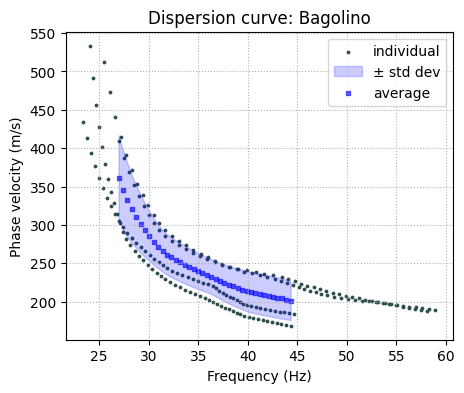

In [44]:
# plot to save
fig = plt.figure(figsize=(5., 4))

# Curve individuali
plt.scatter(x, y, label='individual', color='darkslategray', s=3)

# Banda ± std_dev attorno alla media
plt.fill_between(common_x, mean_vector - std_dev, mean_vector + std_dev,
                 color='b', alpha=0.2, label='± std dev')

# Curva media come quadratini
plt.scatter(common_x, mean_vector, s=10, marker='s', alpha=0.6, color='b', label='average')

# Etichette e legenda
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase velocity (m/s)')
plt.title('Dispersion curve: ' + location)
plt.grid(linestyle=':')
# Salva figura
plt.savefig(figdir + location + '.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


### 3. Save for EvoDCinv and MASWavesPy

In [38]:
print(f'📁 Dispersion curve saved for EvoDCinv in: {outdir}')

out = np.column_stack((common_x, mean_vector))
df = pd.DataFrame(out, columns=['frequency [Hz]', 'c_mean [m/s]'])

df.to_csv(outdir+location+'_evoDC.txt', sep='\t', index=False)
df.head()

📁 Dispersion curve saved for EvoDCinv in: ../data/masw/disp_curves/


,frequency [Hz],c_mean [m/s]
0,26.948052,361.795363
1,27.393440,345.621834
2,27.838828,332.074582
3,28.284216,320.788633
4,28.729604,310.662541


In [39]:
print(f'📁 Dispersion curve saved for MASWavesPy in: {outdir}')

# Save the output file as wavelength-velocity
wavel = mean_vector / common_x # compute wavelenght
clow = mean_vector - std_dev
cup = mean_vector + std_dev

out = np.column_stack((wavel, mean_vector, clow, cup))
df = pd.DataFrame(out, columns=['wavelength [m]', 'c_mean [m/s]', 'c_low [m/s]','c_up [m/s]'])
df_sorted = df.sort_values(by='wavelength [m]')
df_sorted.to_csv(outdir+location+'_maswavesDC.txt', sep='\t', index=False)
df_sorted.head()

📁 Dispersion curve saved for MASWavesPy in: ../data/masw/disp_curves/


,wavelength [m],c_mean [m/s],c_low [m/s],c_up [m/s]
39,4.538449,201.135816,175.943642,226.327989
38,4.619106,202.653107,176.933176,228.373037
37,4.702174,204.203200,177.954914,230.451487
36,4.777759,205.357723,179.005217,231.710229
35,4.854397,206.489685,180.083590,232.895779
